In [ ]:
%load_ext autoreload
%autoreload 2
import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision.transforms.v2 as transforms
import torch.nn as nn

from torchvision.models import resnet34, ResNet34_Weights

from src.lib.models import MultiObjectNet, CustomBackbone
from src.lib.dataset import FashionDataset
from src.lib.utils import create_transforms

In [3]:
cat_names = [
    "no detection",
    "short sleeve top", 
    "long sleeve top", 
    "short sleeve outwear", 
    "long sleeve outwear", 
    "vest", 
    "sling", 
    "shorts", 
    "trousers", 
    "skirt", 
    "short sleeve dress", 
    "long sleeve dress", 
    "vest dress", 
    "sling dress"
    ]

## mAP computation

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def compute_ap_results(model, dataset, device):
    metric = MeanAveragePrecision(iou_type="bbox", box_format="cxcywh", class_metrics=True, extended_summary=True)
    for _img, _cls, _box in tqdm.tqdm(dataset):
        with torch.no_grad():
            _pred_cls, _pred_box = model(_img.to(device))
        _pred_box = _pred_box.cpu()
        _score, _pred_label = _pred_cls.cpu().softmax(-1).max(-1)

        _pred_box = _pred_box[_pred_label != 0]
        _score = _score[ _pred_label != 0]
        _pred_label = _pred_label[_pred_label != 0]
        metric.update(preds=[{
                "boxes": _pred_box,
                "scores": _score,
                "labels": _pred_label
            }],
            target=[{
                "boxes": _box,
                "labels": torch.tensor(_cls)
            }]        
        )
    
    res = metric.compute()

    return res

MAX_OBJS = 5
max_classes = 13 + 1

transforms_test = create_transforms("test", False)
test_dataset = FashionDataset("test", "data/test/annotations", "data/test/images", {"all":transforms_test})

device = torch.device("mps")

# ResNet34 backbone
resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
backbone = nn.Sequential(
        *list(resnet.children())[:-2], # Remove avgpool and fc
        nn.Conv2d(512, 256, 1) # Dimensionality reduction
    )
    
net = MultiObjectNet(in_size=224, 
                     max_objects=MAX_OBJS, 
                     num_classes=max_classes, 
                     backbone=backbone
                    )

net.load_state_dict(torch.load("checkpoints/resnet_backbone.pth"))
net.eval()
net.to(device)
resnet_res = compute_ap_results(net, test_dataset, device)


# Custom backbone
backbone=CustomBackbone(in_size=224,
                        use_self_attention=True, 
                        hidden_dim=64)
    
net = MultiObjectNet(in_size=224, 
                     max_objects=MAX_OBJS, 
                     num_classes=max_classes, 
                     backbone=backbone
                    )

net.load_state_dict(torch.load("checkpoints/custom_backbone.pth"))
net.eval()
net.to(device)
custom_res = compute_ap_results(net, test_dataset, device)


# ResNet34 backbone (ImageNet norm)
transforms_test = create_transforms("test", True)
test_dataset = FashionDataset("test", "data/test/annotations", "data/test/images", {"all":transforms_test})

resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
backbone = nn.Sequential(
        *list(resnet.children())[:-2], # Remove avgpool and fc
        nn.Conv2d(512, 256, 1) # Dimensionality reduction
    )
    
net = MultiObjectNet(in_size=224, 
                     max_objects=MAX_OBJS, 
                     num_classes=max_classes, 
                     backbone=backbone
                    )

net.load_state_dict(torch.load("checkpoints/resnet_backbone_imagenet_norm.pth"))
net.eval()
net.to(device)
imagenet_res = compute_ap_results(net, test_dataset, device)


100%|██████████| 3067/3067 [02:34<00:00, 19.87it/s]


In [77]:
res_list = {"resnet":resnet_res, "imagenet":imagenet_res, "custom":custom_res}
metrics = ["map", "map_50", "map_per_class"]

for r,v in res_list.items():
    for m in metrics:
        if "class" in m:
            v = v[m].tolist()
            print(f"{r} - {m}:{list(zip(cat_names[1:], v))}")
        else:
            print(f"{r} - {m}:{v[m]:.3f}")

resnet - map:0.297
resnet - map_50:0.498
resnet - map_per_class:[('short sleeve top', 0.49419161677360535), ('long sleeve top', 0.3766050338745117), ('short sleeve outwear', 0.0), ('long sleeve outwear', 0.32346147298812866), ('vest', 0.3099527359008789), ('sling', 0.09448597580194473), ('shorts', 0.46038082242012024), ('trousers', 0.5559656023979187), ('skirt', 0.3883894085884094), ('short sleeve dress', 0.2566516101360321), ('long sleeve dress', 0.09926232695579529), ('vest dress', 0.32956117391586304), ('sling dress', 0.17538949847221375)]
imagenet - map:0.256
imagenet - map_50:0.477
imagenet - map_per_class:[('short sleeve top', 0.3907342255115509), ('long sleeve top', 0.3221656084060669), ('short sleeve outwear', 0.0), ('long sleeve outwear', 0.3219691216945648), ('vest', 0.24953177571296692), ('sling', 0.08507984131574631), ('shorts', 0.32896557450294495), ('trousers', 0.4969504177570343), ('skirt', 0.316371887922287), ('short sleeve dress', 0.24768708646297455), ('long sleeve dr

### PR curve plotting

In [97]:
import matplotlib.gridspec as gridspec
from matplotlib import rc
FW = 550
cycler = plt.cycler("color", ["#c95516", "#4254f5","#468f15"])
rc("font", family="FOT-Rodin Pro", weight=FW)
rc("axes", prop_cycle=cycler) 


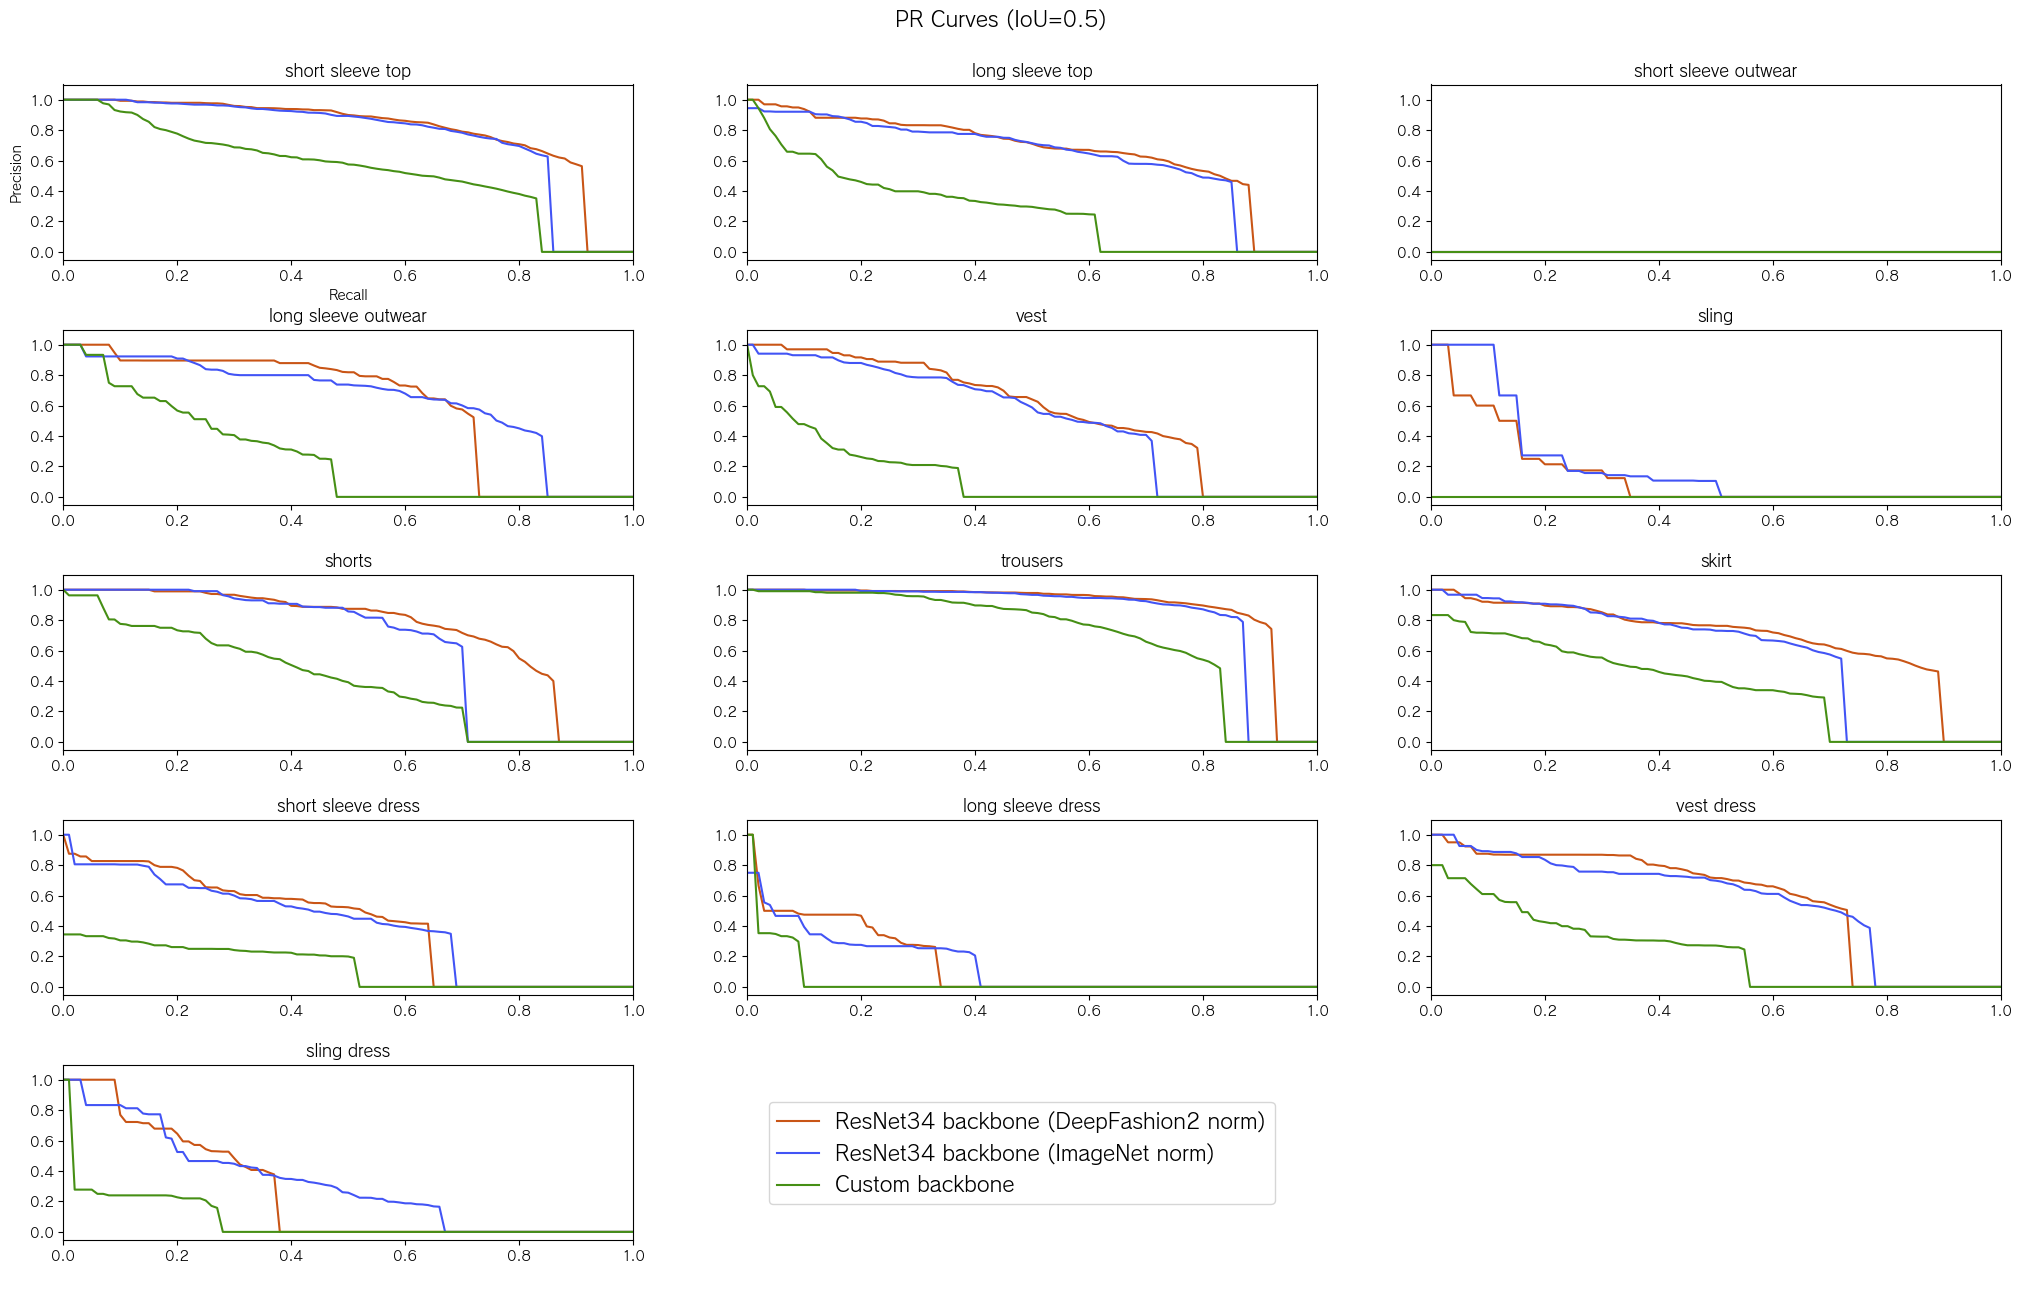

In [98]:
fig = plt.figure(figsize=(25,15))
#gs = gridspec.GridSpec(4, 4, fig, hspace=0.3)
gs = gridspec.GridSpec(5, 3, fig, hspace=0.4)

t = 0
a = 0
m = -1



#fig, axs = plt.subplots(4,4, figsize=(20,12))
for c in range(0,12):
    ax = fig.add_subplot(gs[c//3,c%3])
    prec_curve_imagenet = imagenet_res["precision"][t, :, c, a, m]  # IoU=0.5
    prec_curve_resnet = resnet_res["precision"][t, :, c, a, m]  # IoU=0.5
    prec_curve_custom = custom_res["precision"][t, :, c, a, m]  # IoU=0.5
    if torch.all(prec_curve_resnet == -1) and torch.all(prec_curve_custom == -1):  # skip if empty
        continue
    rec_curve = torch.linspace(0, 1, steps=prec_curve_resnet.numel())
    ax.plot(rec_curve.numpy(), prec_curve_resnet.numpy(), label=f"ResNet34 backbone")
    ax.plot(rec_curve.numpy(), prec_curve_imagenet.numpy(), label=f"ResNet34 backbone (imagenet)")
    ax.plot(rec_curve.numpy(), prec_curve_custom.numpy(), label=f"Custom backbone")
    ax.set_title(f"{cat_names[c+1]}", fontweight=FW)
    ax.set_xlim(0,1)
    ax.set_ylim(-0.05,1.1)
    if c == 0:
        ax.set_xlabel("Recall", fontdict={"weight":500})
        ax.set_ylabel("Precision", fontdict={"weight":500})
    #ax.title()

c = 12
ax = fig.add_subplot(gs[-1,0])
prec_curve_imagenet = imagenet_res["precision"][t, :, c, a, m]  # IoU=0.5
prec_curve_resnet = resnet_res["precision"][t, :, c, a, m]  # IoU=0.5
prec_curve_custom = custom_res["precision"][t, :, c, a, m]  # IoU=0.5
rec_curve = torch.linspace(0, 1, steps=prec_curve_resnet.numel())
ax.plot(rec_curve.numpy(), prec_curve_resnet.numpy(), label=f"ResNet34 backbone (DeepFashion2 norm)")
ax.plot(rec_curve.numpy(), prec_curve_imagenet.numpy(), label=f"ResNet34 backbone (ImageNet norm)")
ax.plot(rec_curve.numpy(), prec_curve_custom.numpy(), label=f"Custom backbone")
ax.set_title(f"{cat_names[c+1]}", fontweight=FW)
ax.set_xlim(0,1)
ax.set_ylim(-0.05,1.1)

fig.suptitle(f"PR Curves (IoU=0.5)", fontsize=15, y=0.93, fontweight=FW)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc=(0.28,0.1), fontsize=15)
fig.legend(handles, labels, loc=(0.38,0.075), fontsize=15)
#plt.grid()
plt.show()
fig.savefig("pr_curves_2.png", dpi=220, bbox_inches="tight")

In [ ]:
print(resnet_res["map"])
print(resnet_res["map_50"])
print(resnet_res["map_75"])
print([(cat_names[i+1],el.item()) for i,el in enumerate(resnet_res["map_per_class"])])

print(custom_res["map"])
print(custom_res["map_50"])
print(custom_res["map_75"])
print([(cat_names[i+1],el.item()) for i,el in enumerate(custom_res["map_per_class"])])

print(imagenet_res["map"])
print(imagenet_res["map_50"])
print(imagenet_res["map_75"])
print([(cat_names[i+1],el.item()) for i,el in enumerate(imagenet_res["map_per_class"])])

## Class distribution in the train split

In [12]:
from collections import Counter
from torch.utils.data import DataLoader

def c(batch):
    _,cl,_ = zip(*batch)
    cl = [torch.tensor(el).flatten() for el in cl]
    return torch.cat(cl)
train_dataset = FashionDataset("train", "data/train/annotations", "data/train/images")
train_dataloader = DataLoader(train_dataset, 64, False, collate_fn=c)
class_list = {cat_names[i]:0 for i in range(1,14)}
for cl in tqdm.tqdm(train_dataloader):
    for i in cl:
        class_list[cat_names[i]] += 1

counter = Counter(class_list)

100%|██████████| 286/286 [00:08<00:00, 33.92it/s]


13


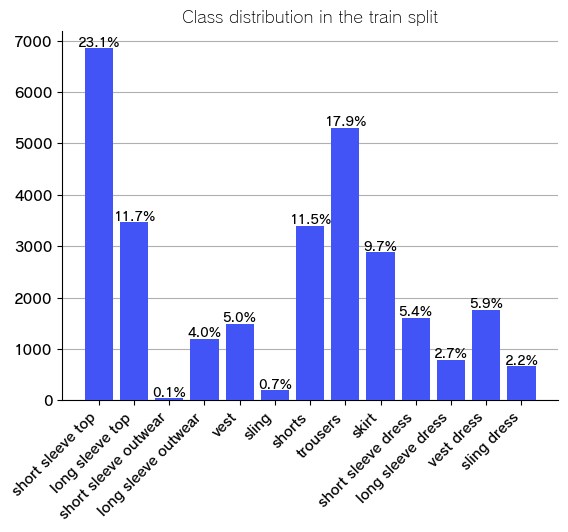

In [91]:
print(len(class_list))
fig, ax = plt.subplots()
plt.grid(axis="y", zorder=-10)
bars = ax.bar(class_list.keys(), class_list.values(), zorder=10, color="#4254f5")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

ax.spines[['right', 'top']].set_visible(False) 


ax.bar_label(bars, fmt=lambda x: f"{100*x/counter.total():.1f}%", fontsize=9)
plt.title("Class distribution in the train split")
plt.show()